In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## TAREA 1
Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



### Chunk 1 : Detección de monedas(usando hough)

Metodo: Hough | Monedas detectadas: 8


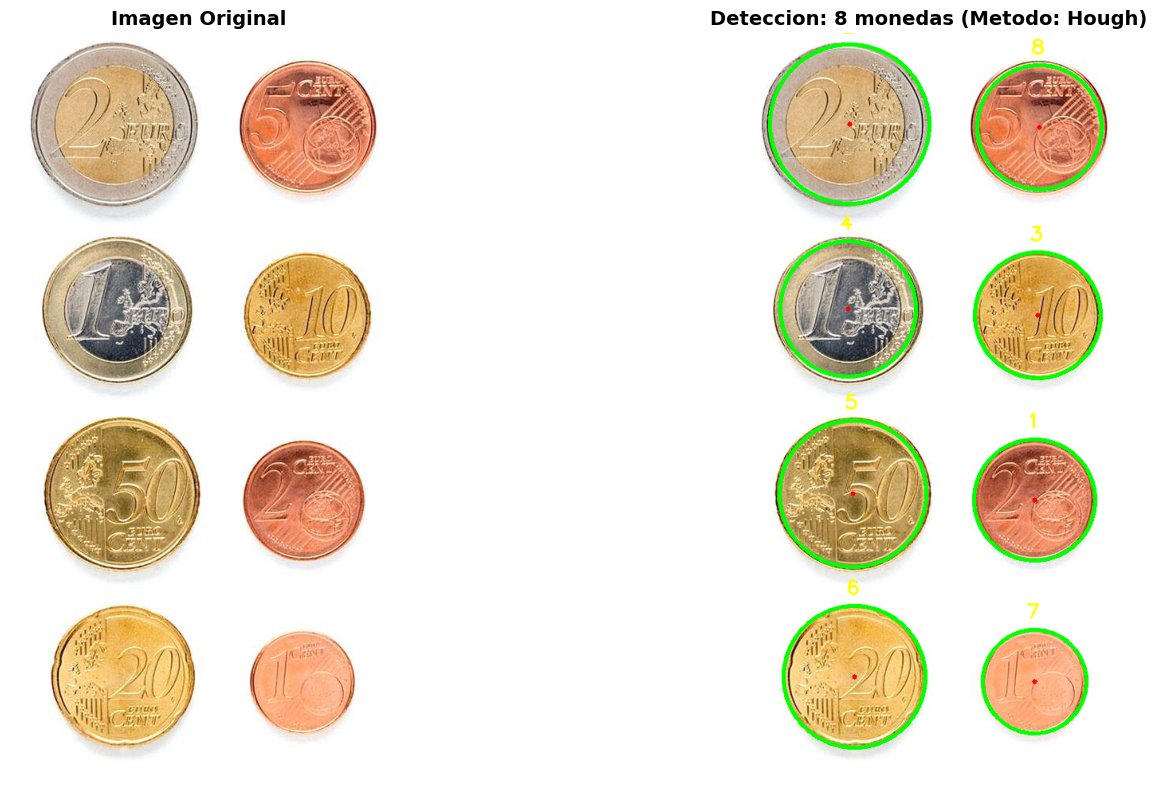

In [21]:
IMAGE_PATH = "Monedas.jpg"

img = cv2.imread(IMAGE_PATH)

if img is None:
    raise SystemExit(f"Error: No se pudo cargar la imagen '{IMAGE_PATH}'")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

height, width = img_gray.shape

HOUGH_PARAM1 = 70
HOUGH_PARAM2 = 70

min_dimension = min(height, width)
min_radius = int(min_dimension * 0.03)
max_radius = int(min_dimension * 0.3)
min_dist = int(min_dimension * 0.08)

blurred = cv2.GaussianBlur(img_gray, (7, 7), 0)
blurred = cv2.medianBlur(blurred, 5)

circles_hough = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=min_dist,
    param1=HOUGH_PARAM1,
    param2=HOUGH_PARAM2,
    minRadius=min_radius,
    maxRadius=max_radius
)

circles_detected = []
method_used = "Hough"

if circles_hough is not None:
    circles_hough = np.uint16(np.around(circles_hough[0]))
    for (x, y, r) in circles_hough:
        circles_detected.append({
            'x': int(x),
            'y': int(y),
            'radius': float(r),
            'color_type': None,
            'diameter_mm': None,
            'confidence': 0.0
        })

if len(circles_detected) == 0:
    raise SystemExit("No se detectaron monedas con ningun metodo")

print(f"Metodo: {method_used} | Monedas detectadas: {len(circles_detected)}")

img_detection = img_rgb.copy()

for i, coin in enumerate(circles_detected):
    cv2.circle(img_detection, (coin['x'], coin['y']), int(coin['radius']), 
               (0, 255, 0), 3)
    
    cv2.circle(img_detection, (coin['x'], coin['y']), 3, (255, 0, 0), -1)
    
    cv2.putText(img_detection, str(i+1), 
                (coin['x'] - 10, coin['y'] - int(coin['radius']) - 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

# Create subplot with both images
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Original image
axes[0].imshow(img_rgb)
axes[0].set_title('Imagen Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Detection result
axes[1].imshow(img_detection)
axes[1].set_title(f'Deteccion: {len(circles_detected)} monedas (Metodo: {method_used})', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Chunk 2 : Clasificación de colores


Cobre: 3 | Oro: 3 | Plata: 2


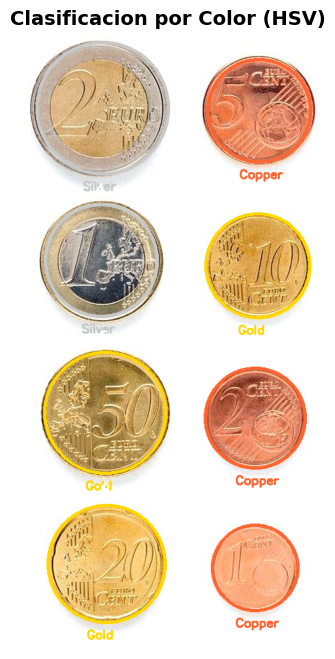

In [22]:
HSV_RANGES = {
    "copper": ((0, 50, 40), (20, 255, 150)),
    "gold":   ((20, 40, 80), (50, 255, 255)),
    "silver": ((0, 0, 100), (180, 50, 255))
}

mask_copper = cv2.inRange(img_hsv, HSV_RANGES["copper"][0], HSV_RANGES["copper"][1])
mask_gold = cv2.inRange(img_hsv, HSV_RANGES["gold"][0], HSV_RANGES["gold"][1])
mask_silver = cv2.inRange(img_hsv, HSV_RANGES["silver"][0], HSV_RANGES["silver"][1])

for i, coin in enumerate(circles_detected):
    mask_coin = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
    cv2.circle(mask_coin, (coin['x'], coin['y']), int(coin['radius']), 255, -1)
    
    copper_pixels = cv2.countNonZero(cv2.bitwise_and(mask_copper, mask_coin))
    gold_pixels = cv2.countNonZero(cv2.bitwise_and(mask_gold, mask_coin))
    silver_pixels = cv2.countNonZero(cv2.bitwise_and(mask_silver, mask_coin))
    total_pixels = cv2.countNonZero(mask_coin)
    
    if total_pixels == 0:
        continue
    
    copper_ratio = copper_pixels / total_pixels
    gold_ratio = gold_pixels / total_pixels
    silver_ratio = silver_pixels / total_pixels
    
    silver_to_gold_ratio = silver_ratio / gold_ratio if gold_ratio > 0 else 0
    copper_to_gold_ratio = copper_ratio / gold_ratio if gold_ratio > 0 else 0
    silver_to_copper_ratio = silver_ratio / copper_ratio if copper_ratio > 0 else 0

    if (copper_ratio < gold_ratio) and silver_to_copper_ratio >= 0.8 and silver_to_gold_ratio >= 0.2:
        coin['color_type'] = "silver"
        coin['confidence'] = 0.95
        color_name = "Plata"
    elif copper_ratio > gold_ratio or copper_to_gold_ratio >= 0.7:
        coin['color_type'] = "copper"
        coin['confidence'] = copper_ratio
        color_name = "Cobre"
    else:
        coin['color_type'] = "gold"
        coin['confidence'] = gold_ratio
        color_name = "Oro"
    
    #print(f"Moneda #{i+1}: {color_name} (C:{copper_ratio:.2f} | G:{gold_ratio:.2f} | S:{silver_ratio:.2f})"
     #     f" ---- Ratio copper to gold :{copper_to_gold_ratio:.2f} | silver to gold ratio:{silver_to_gold_ratio:.2f} | silver to copper:{silver_to_copper_ratio:.2f}")

color_counts = {"copper": 0, "gold": 0, "silver": 0}
for coin in circles_detected:
    if coin['color_type']:
        color_counts[coin['color_type']] += 1

print(f"\nCobre: {color_counts['copper']} | Oro: {color_counts['gold']} | Plata: {color_counts['silver']}")

img_color_class = img_rgb.copy()

color_map = {
    "copper": (255, 100, 50),
    "gold": (255, 215, 0),
    "silver": (200, 200, 200)
}

for i, coin in enumerate(circles_detected):
    if coin['color_type']:
        color = color_map[coin['color_type']]
        
        cv2.circle(img_color_class, (coin['x'], coin['y']), int(coin['radius']), color, 4)
        
        label = coin['color_type'].capitalize()
        cv2.putText(img_color_class, label,
                    (coin['x'] - 30, coin['y'] + int(coin['radius']) + 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        cv2.putText(img_color_class, str(i+1),
                    (coin['x'] - 10, coin['y'] - int(coin['radius']) - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(img_color_class)
plt.title('Clasificacion por Color (HSV)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

### Chunk 3: Clasificación de tamaño y de valor

En este chunk se realiza una última verificación de que el colo rfue correctamente elegido, para ello se contrastan los ratios de tamaño con los de color. Y finalmente calculamos el valor total de las monedas que hay en la imagen

Referencia: 50c | Escala: 0.1318 mm/px

  Moneda #1 | Color: copper | Radio: 76.0px | Diam: 20.0mm | Size_ratio: 0.826
      1c: diam_esp=16.25mm (Δ3.78mm) | ratio_esp=0.670 (Δ0.156) | score=11.5038
      2c: diam_esp=19.75mm (Δ0.28mm) | ratio_esp=0.814 (Δ0.012) | score=0.8595
      5c: diam_esp=21.25mm (Δ1.22mm) | ratio_esp=0.876 (Δ0.050) | score=3.7024
  -> ELEGIDO: 2c | 20.0mm (Δ0.28mm) | conf=0.91

  Moneda #2 | Color: silver | Radio: 100.0px | Diam: 26.4mm | Size_ratio: 1.087
      1€: diam_esp=23.25mm (Δ3.11mm) | ratio_esp=0.959 (Δ0.128) | score=9.4543
      2€: diam_esp=25.75mm (Δ0.61mm) | ratio_esp=1.062 (Δ0.025) | score=1.8512
  -> ELEGIDO: 2€ | 26.4mm (Δ0.61mm) | conf=0.81

  Moneda #3 | Color: gold | Radio: 79.0px | Diam: 20.8mm | Size_ratio: 0.859
     10c: diam_esp=19.75mm (Δ1.07mm) | ratio_esp=0.814 (Δ0.044) | score=3.2644
     20c: diam_esp=22.75mm (Δ1.93mm) | ratio_esp=0.938 (Δ0.079) | score=5.8593
     50c: diam_esp=24.25mm (Δ3.43mm) | ratio_esp=1.000 (Δ0.141) | score=

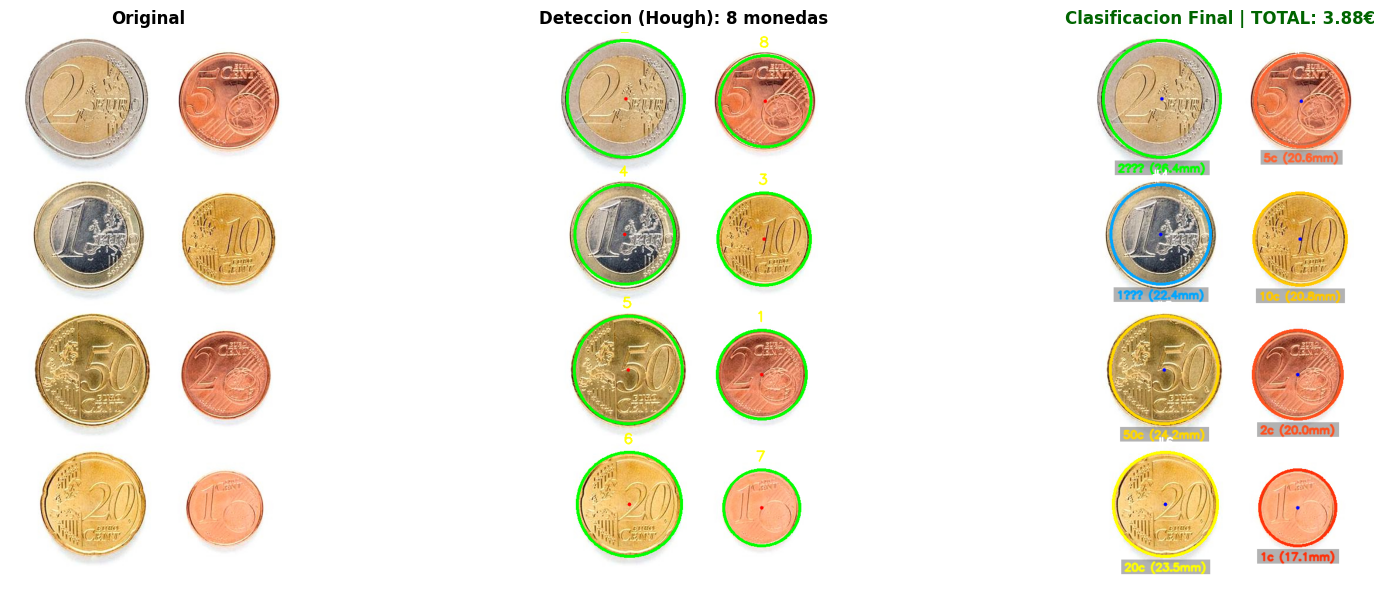

In [23]:
COIN_DIAMETERS_MM = {
    "2€": 25.75, "1€": 23.25,
    "50c": 24.25, "20c": 22.75, "10c": 19.75,
    "5c": 21.25, "2c": 19.75, "1c": 16.25,
}
COIN_VALUES = {
    "2€": 2.00, "1€": 1.00,
    "50c": 0.50, "20c": 0.20, "10c": 0.10,
    "5c": 0.05, "2c": 0.02, "1c": 0.01
}
COIN_COLORS = {
    "2€": (0, 255, 0), "1€": (0, 165, 255),
    "50c": (255, 215, 0), "20c": (255, 255, 0), "10c": (255, 200, 0),
    "5c": (255, 100, 50), "2c": (255, 80, 30), "1c": (255, 50, 10)
}
COLOR_GROUPS = {
    "copper": ["1c", "2c", "5c"],
    "gold":   ["10c", "20c", "50c"],
    "silver": ["1€", "2€"]
}
SIZE_TOLERANCE = 0.12

groups = {"copper": [], "gold": [], "silver": []}
for coin in circles_detected:
    if coin['color_type']:
        groups[coin['color_type']].append(coin)

ref_name = None
ref_coin = None

if len(groups["gold"]) > 0:
    ref_name = "50c"
    ref_coin = max(groups["gold"], key=lambda c: c['radius'])
elif len(groups["copper"]) > 0:
    ref_name = "5c"
    ref_coin = max(groups["copper"], key=lambda c: c['radius'])
else:
    ref_name = "2€"
    ref_coin = max(groups["silver"], key=lambda c: c['radius'])

if not ref_coin:
    raise SystemExit("No se pudo determinar moneda de referencia")

ref_diameter_mm = COIN_DIAMETERS_MM[ref_name]
ref_diameter_px = 2.0 * ref_coin['radius']
scale_factor = ref_diameter_mm / ref_diameter_px

print(f"Referencia: {ref_name} | Escala: {scale_factor:.4f} mm/px")

ratios = {name: COIN_DIAMETERS_MM[name] / ref_diameter_mm 
          for name in COIN_DIAMETERS_MM.keys()}

classified_count = 0

for i, coin in enumerate(circles_detected):
    coin['diameter_mm'] = (2.0 * coin['radius']) * scale_factor
    size_ratio = coin['radius'] / ref_coin['radius']
    
    valid_names = COLOR_GROUPS.get(coin['color_type'], list(COIN_DIAMETERS_MM.keys()))
    
    print(f"\n  Moneda #{i+1} | Color: {coin['color_type']} | Radio: {coin['radius']:.1f}px | Diam: {coin['diameter_mm']:.1f}mm | Size_ratio: {size_ratio:.3f}")
    
    candidates = []
    
    for name in valid_names:
        expected_diameter = COIN_DIAMETERS_MM[name]
        expected_ratio = ratios[name]
        
        diameter_diff = abs(coin['diameter_mm'] - expected_diameter)
        ratio_diff = abs(size_ratio - expected_ratio)
        
        combined_score = (diameter_diff * 3) + ratio_diff
        
        candidates.append({
            'name': name,
            'expected_diameter': expected_diameter,
            'diameter_diff': diameter_diff,
            'expected_ratio': expected_ratio,
            'ratio_diff': ratio_diff,
            'score': combined_score
        })
        
        print(f"    {name:>4s}: diam_esp={expected_diameter:.2f}mm (Δ{diameter_diff:.2f}mm) | "
              f"ratio_esp={expected_ratio:.3f} (Δ{ratio_diff:.3f}) | score={combined_score:.4f}")
    
    candidates.sort(key=lambda x: x['score'])
    best = candidates[0]
    
    coin['denomination'] = best['name']
    
    max_possible_score = 10.0
    coin['confidence'] = max(0.0, min(1.0, 1.0 - (best['score'] / max_possible_score)))
    classified_count += 1
    
    print(f"  -> ELEGIDO: {coin['denomination']} | {coin['diameter_mm']:.1f}mm (Δ{best['diameter_diff']:.2f}mm) | conf={coin['confidence']:.2f}")

total_value = 0.0
count_by_type = {}

for coin in circles_detected:
    total_value += COIN_VALUES[coin['denomination']]
    denom = coin['denomination']
    count_by_type[denom] = count_by_type.get(denom, 0) + 1

print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)

if count_by_type:
    sorted_items = sorted(count_by_type.items(), 
                        key=lambda x: COIN_VALUES[x[0]], 
                        reverse=True)
    for denomination, count in sorted_items:
        value = COIN_VALUES[denomination] * count
        print(f"{denomination:>4s}: {count:2d} moneda(s) -> {value:6.2f}€")

print(f"\nTOTAL: {total_value:.2f}€")
print("="*70)

img_final = img_rgb.copy()

for i, coin in enumerate(circles_detected):
    color = COIN_COLORS.get(coin['denomination'], (200, 200, 200))
    
    cv2.circle(img_final, (coin['x'], coin['y']), int(coin['radius']), color, 3)
    cv2.circle(img_final, (coin['x'], coin['y']), 3, (0, 0, 255), -1)
    
    cv2.putText(img_final, f"#{i+1}", 
                (coin['x'] - 15, coin['y'] - int(coin['radius']) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    text = f"{coin['denomination']} ({coin['diameter_mm']:.1f}mm)"
    
    (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    text_x = coin['x'] - w // 2
    text_y = coin['y'] + int(coin['radius']) + 25
    
    overlay = img_final.copy()
    cv2.rectangle(overlay, (text_x - 5, text_y - h - 5), 
                 (text_x + w + 5, text_y + 5), (0, 0, 0), -1)
    img_final = cv2.addWeighted(img_final, 0.7, overlay, 0.3, 0)
    
    cv2.putText(img_final, text, (text_x, text_y),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_rgb)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_detection)
axes[1].set_title(f'Deteccion ({method_used}): {len(circles_detected)} monedas', 
                 fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(img_final)
axes[2].set_title(f'Clasificacion Final | TOTAL: {total_value:.2f}€', 
                 fontsize=12, fontweight='bold', color='darkgreen')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## TAREA 2
 La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# -----------------------------------------------------
# CONFIGURACIÓN
# -----------------------------------------------------
TRAIN_IMGS = {
    "PEL": "PEL.png",
    "FRA": "FRA.png",
    "TAR": "TAR.png"
}
TEST_IMG = "MPs_test.jpg"
TEST_CSV = "MPs_test_bbs.csv"
LABELS = ["PEL", "FRA", "TAR"]

# -----------------------------------------------------
# FUNCIONES AUXILIARES
# -----------------------------------------------------
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {path}")
    return img

def preprocess_gray(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    return gray

def segment_by_otsu(gray):
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(th) < 127:
        th = 255 - th
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)
    return th

def contours_from_mask(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return cnts

def extract_features_from_contour(contour, img):
    f = {}
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    f['area'] = area
    f['perimeter'] = perimeter
    f['compactness'] = (perimeter**2 / area) if area > 0 else 0

    x,y,w,h = cv2.boundingRect(contour)
    f['bbox_w'] = w
    f['bbox_h'] = h
    f['bbox_ar'] = w/h if h > 0 else 0
    f['area_bbox_ratio'] = area / (w*h) if w*h > 0 else 0

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    f['solidity'] = area / hull_area if hull_area > 0 else 0

    if len(contour) >= 5:
        (_, _), (MA, ma), _ = cv2.fitEllipse(contour)
        f['ellipse_ratio'] = max(MA, ma)/min(MA, ma) if min(MA,ma) > 0 else 1
    else:
        f['ellipse_ratio'] = 1

    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = M['m10']/M['m00']; cy = M['m01']/M['m00']
        pts = contour.reshape(-1,2)
        dists = np.linalg.norm(pts - np.array([cx,cy]), axis=1)
        f['dist_ratio_minmax'] = np.min(dists)/np.max(dists) if np.max(dists) > 0 else 0
    else:
        f['dist_ratio_minmax'] = 0

    # Hu Moments
    hu = cv2.HuMoments(M).flatten()
    for i in range(7):
        f[f'hu{i+1}'] = hu[i]

    # Color RGB
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mask_bool = mask==255
    pixels_bgr = img[mask_bool]
    if len(pixels_bgr)>0:
        f['mean_b'], f['mean_g'], f['mean_r'] = np.mean(pixels_bgr, axis=0)
        f['std_b'], f['std_g'], f['std_r'] = np.std(pixels_bgr, axis=0)
    else:
        f['mean_b']=f['mean_g']=f['mean_r']=0
        f['std_b']=f['std_g']=f['std_r']=0

    # Color HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixels_hsv = img_hsv[mask_bool]
    if len(pixels_hsv)>0:
        f['mean_h'], f['mean_s'], f['mean_v'] = np.mean(pixels_hsv, axis=0)
        f['std_h'], f['std_s'], f['std_v'] = np.std(pixels_hsv, axis=0)
    else:
        f['mean_h']=f['mean_s']=f['mean_v']=0
        f['std_h']=f['std_s']=f['std_v']=0

    return f

# -----------------------------------------------------
# ENTRENAMIENTO
# -----------------------------------------------------
def build_training_data(train_imgs):
    X, y = [], []
    feature_names = None
    for label, path in train_imgs.items():
        img = load_image(path)
        gray = preprocess_gray(img)
        mask = segment_by_otsu(gray)
        cnts = contours_from_mask(mask)
        for c in cnts:
            if cv2.contourArea(c) < 50:
                continue
            feats = extract_features_from_contour(c, img)
            if feature_names is None:
                feature_names = list(feats.keys())
            X.append([feats[f] for f in feature_names])
            y.append(label)
    return np.array(X), np.array(y), feature_names

# -----------------------------------------------------
# EVALUACIÓN
# -----------------------------------------------------
def read_bboxes_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    required = ['label','x_min','y_min','x_max','y_max']
    if not set(required).issubset(df.columns):
        raise ValueError(f"CSV debe tener {required}")
    return df

def evaluate_model(clf, feature_names, test_img_path, test_csv_path):
    img = load_image(test_img_path)
    df = read_bboxes_csv(test_csv_path)
    y_true, y_pred, results = [], [], []

    for _, row in df.iterrows():
        x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
        patch = img[y1:y2, x1:x2]
        if patch.size==0:
            continue
        gray_patch = preprocess_gray(patch)
        mask_patch = segment_by_otsu(gray_patch)
        cnts = contours_from_mask(mask_patch)
        if len(cnts)==0:
            pred_label="FRA"
        else:
            largest=max(cnts,key=cv2.contourArea)
            feats=extract_features_from_contour(largest, patch)
            X_test = np.array([feats[f] for f in feature_names]).reshape(1,-1)
            pred_label = clf.predict(X_test)[0]

        y_true.append(str(row['label']).upper())
        y_pred.append(pred_label)
        results.append((x1,y1,x2,y2,str(row['label']).upper(), pred_label))

    # Métricas
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.3f}")
    print(pd.DataFrame(classification_report(y_true, y_pred, labels=LABELS, output_dict=True)).transpose().round(3))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Visualización
    img_out = img.copy()
    for (x1,y1,x2,y2,true,pred) in results:
        color = (0,255,0) if true==pred else (0,0,255)
        cv2.rectangle(img_out,(x1,y1),(x2,y2),color,2)
        cv2.putText(img_out,pred,(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1)

    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicciones sobre la imagen (Accuracy={acc:.2f})")
    plt.axis('off')
    plt.show()

# -----------------------------------------------------
# MAIN
# -----------------------------------------------------
if __name__=="__main__":
    print("Extrayendo características de entrenamiento...")
    X_train, y_train, feature_names = build_training_data(TRAIN_IMGS)
    print(f"Se extrajeron {len(X_train)} muestras.")

    print("Entrenando Random Forest...")
    clf = RandomForestClassifier(n_estimators=500, max_depth=15, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)

    print("Evaluando sobre la imagen de test...")
    evaluate_model(clf, feature_names, TEST_IMG, TEST_CSV)


In [ ]:
import cv2
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# -----------------------------------------------------
# CONFIGURACIÓN
# -----------------------------------------------------
# Imágenes de entrenamiento 
TRAIN_IMGS = {
    "PEL": "PEL.png",
    "FRA": "FRA.png",
    "TAR": "TAR.png"
}

# Imagen de prueba para validación
VAL_IMG = "MPs_test.jpg"
VAL_CSV = "MPs_test_bbs.csv"

# Imagen de aplicación (variable)
TEST_IMG = "MPs_test.jpg"  

SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {DEVICE}")
LABELS = ["PEL", "FRA", "TAR"]

# Parámetros SAM
POINTS_PER_SIDE = 32
PRED_IOU_THRESH = 0.95
STABILITY_THRESH = 0.95 
MIN_MASK_AREA = 100

# -----------------------------------------------------
# CARGA DE MODELO SAM
# -----------------------------------------------------
print("Cargando modelo SAM...")
sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=POINTS_PER_SIDE,
    pred_iou_thresh=PRED_IOU_THRESH,
    stability_score_thresh=STABILITY_THRESH,
    min_mask_region_area=MIN_MASK_AREA
)
print("SAM cargado correctamente en", DEVICE)

# -----------------------------------------------------
# FUNCIONES AUXILIARES
# -----------------------------------------------------
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_bboxes_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    required = ['label', 'x_min', 'y_min', 'x_max', 'y_max']
    if not set(required).issubset(df.columns):
        raise ValueError(f"El CSV debe tener las columnas {required}, pero se encontraron {list(df.columns)}")
    return df

def extract_features_from_mask(mask, gray):
    feats = {}
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    feats['area'] = area
    feats['perimeter'] = perimeter
    feats['compactness'] = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
    feats['roughness'] = (perimeter**2) / area if area > 0 else 0

    x, y, w, h = cv2.boundingRect(contour)
    feats['bbox_w'] = w
    feats['bbox_h'] = h
    feats['bbox_ar'] = w / h if h > 0 else 0
    feats['extent'] = area / (w * h) if w * h > 0 else 0

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    feats['solidity'] = area / hull_area if hull_area > 0 else 0

    if len(contour) >= 5:
        try:
            ellipse = cv2.fitEllipse(contour)
            (cx, cy), (MA, ma), angle = ellipse
            feats['ellipse_major'] = max(MA, ma)
            feats['ellipse_minor'] = min(MA, ma)
            feats['ellipse_ratio'] = feats['ellipse_major'] / feats['ellipse_minor'] if feats['ellipse_minor'] > 0 else 1
        except:
            feats['ellipse_ratio'] = 1
    else:
        feats['ellipse_ratio'] = 1

    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = M['m10'] / M['m00']
        cy = M['m01'] / M['m00']
        pts = contour.reshape(-1, 2)
        dists = np.linalg.norm(pts - np.array([cx, cy]), axis=1)
        feats['dist_ratio_minmax'] = np.min(dists) / np.max(dists) if np.max(dists) > 0 else 0
    else:
        feats['dist_ratio_minmax'] = 0

    mask_uint8 = mask.astype(np.uint8)
    pixels = gray[mask_uint8 == 1]
    if len(pixels) > 0:
        feats['mean_intensity'] = np.mean(pixels)
        feats['std_intensity'] = np.std(pixels)
    else:
        feats['mean_intensity'] = 0
        feats['std_intensity'] = 0

    return feats

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusión', fontsize=14, pad=15)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# RANDOM FOREST
# -----------------------------------------------------
def build_training_dataset(train_imgs_dict):
    """Construye dataset de entrenamiento desde imágenes individuales por clase"""
    features_list = []
    
    for label, img_path in train_imgs_dict.items():
        print(f"\nProcesando imagen de entrenamiento: {label} ({img_path})")
        img = load_image(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        masks_sam = mask_generator.generate(img)
        print(f"SAM detectó {len(masks_sam)} máscaras")
        
        for mask_info in masks_sam:
            mask = mask_info['segmentation']
            feats = extract_features_from_mask(mask, gray)
            if feats is not None:
                feats["label"] = label
                features_list.append(feats)
    
    feat_df = pd.DataFrame(features_list)
    print(f"\nDataset de entrenamiento creado: {feat_df.shape[0]} partículas, {feat_df.shape[1]-1} features")
    print(f"Distribución de clases:\n{feat_df['label'].value_counts()}\n")
    return feat_df

def train_random_forest(feature_df, model_path="rf_model.pkl"):
    """Entrena el modelo Random Forest"""
    X = feature_df.drop(columns=["label"])
    y = feature_df["label"]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=3,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42
    )
    clf.fit(X_train, y_train)

    y_pred_val = clf.predict(X_val)
    print("\n===== VALIDACIÓN RANDOM FOREST (TRAIN SET) =====")
    print(classification_report(y_val, y_pred_val, labels=LABELS, zero_division=0))
    print(f"Accuracy validación: {accuracy_score(y_val, y_pred_val):.3f}\n")

    joblib.dump(clf, model_path)
    print(f"Modelo Random Forest guardado en {model_path}\n")
    return clf

def classify_by_model(features, model):
    """Clasifica una partícula usando el modelo entrenado"""
    if features is None:
        return "FRA"
    X = pd.DataFrame([features])
    return model.predict(X)[0]

# -----------------------------------------------------
# VALIDACIÓN CON CSV
# -----------------------------------------------------
def validate_with_csv(val_img_path, val_csv_path, model):
    """Valida el modelo usando la imagen de prueba y CSV"""
    img = load_image(val_img_path)
    df = read_bboxes_csv(val_csv_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    masks_sam = mask_generator.generate(img)

    y_true, y_pred = [], []

    for i, row in df.iterrows():
        gt_box = (int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max']))
        true_label = str(row['label']).strip().upper()
        
        best_iou, best_mask = 0, None
        for mask_info in masks_sam:
            mask = mask_info['segmentation']
            ys, xs = np.where(mask)
            if len(xs) == 0:
                continue
            mask_box = (xs.min(), ys.min(), xs.max(), ys.max())
            
            # Calcular IoU
            x1 = max(gt_box[0], mask_box[0])
            y1 = max(gt_box[1], mask_box[1])
            x2 = min(gt_box[2], mask_box[2])
            y2 = min(gt_box[3], mask_box[3])
            intersection = max(0, x2 - x1) * max(0, y2 - y1)
            area1 = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
            area2 = (mask_box[2] - mask_box[0]) * (mask_box[3] - mask_box[1])
            union = area1 + area2 - intersection
            current_iou = intersection / union if union > 0 else 0
            
            if current_iou > best_iou:
                best_iou = current_iou
                best_mask = mask_info

        if best_iou >= 0.3 and best_mask is not None:
            feats = extract_features_from_mask(best_mask['segmentation'], gray)
            pred_label = classify_by_model(feats, model)
        else:
            pred_label = "FRA"

        y_true.append(true_label)
        y_pred.append(pred_label)

    print("\n===== VALIDACIÓN CON CSV =====")
    print(classification_report(y_true, y_pred, labels=LABELS, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plot_confusion_matrix(cm, LABELS)

# -----------------------------------------------------
# APLICACIÓN A IMAGEN DE PRUEBA
# -----------------------------------------------------
def classify_and_visualize(test_img_path, model, output_path="resultado.png"):
    """Clasifica partículas en imagen de prueba y visualiza resultados"""
    img = load_image(test_img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    masks_sam = mask_generator.generate(img)
    
    print(f"\nClasificando partículas en: {test_img_path}")
    print(f"SAM detectó {len(masks_sam)} máscaras")
    
    # Colores para cada clase
    colors = {
        "PEL": (0, 255, 0),    # Verde
        "FRA": (255, 0, 0),    # Rojo
        "TAR": (0, 0, 255)     # Azul
    }
    
    result_img = img.copy()
    classifications = []
    
    for i, mask_info in enumerate(masks_sam):
        mask = mask_info['segmentation']
        feats = extract_features_from_mask(mask, gray)
        pred_label = classify_by_model(feats, model)
        
        # Dibujar contorno con color según clase
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            color = colors.get(pred_label, (255, 255, 255))
            cv2.drawContours(result_img, [contour], 0, color, 2)
            
            # Añadir etiqueta
            M = cv2.moments(contour)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                cv2.putText(result_img, pred_label, (cx - 10, cy), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        classifications.append(pred_label)
    
    # Mostrar imagen
    plt.figure(figsize=(14, 10))
    plt.imshow(result_img)
    plt.title(f"Clasificación de Partículas - {test_img_path}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    
    # Guardar resultado
    result_img_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, result_img_bgr)
    print(f"✓ Imagen guardada en: {output_path}")
    
    # Mostrar estadísticas
    print(f"\nEstadísticas de clasificación:")
    for label in LABELS:
        count = classifications.count(label)
        print(f"  {label}: {count} partículas")
    
    plt.show()
    return result_img

# -----------------------------------------------------
# MAIN
# -----------------------------------------------------
if __name__ == "__main__":
    print("=" * 60)
    print("CLASIFICACIÓN DE MICROPLÁSTICOS CON SAM + RANDOM FOREST")
    print("=" * 60)

    # Paso 1: Construir dataset desde imágenes de entrenamiento
    feat_df = build_training_dataset(TRAIN_IMGS)

    # Paso 2: Entrenar modelo RF
    rf_model = train_random_forest(feat_df)

    # Paso 3: Validar con CSV
    validate_with_csv(VAL_IMG, VAL_CSV, rf_model)

    # Paso 4: Aplicar a imagen de prueba y visualizar
    classify_and_visualize(TEST_IMG, rf_model, output_path="clasificacion_resultado.png")